In [5]:
import pandas as pd
import pyeto
import numpy as np
import model.integrated_model as model
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


# 载入数据

In [6]:
# Integrated Hydrological Model
def calculate_runoff(precipitation,et):
    infiltration_rate= 0.0044493533287026255
    percolation_rate= 0.0015114617133019205
    baseflow_rate= 0.018787726309103157
    upper_zone_storage= 640.1599637595345
    lower_zone_storage= 0.0
    Area = 86.4

    params = [infiltration_rate, percolation_rate, baseflow_rate, upper_zone_storage, lower_zone_storage]
    runoff, _, _= model.integrated_model(params, precipitation, et,Area)

    return runoff

In [9]:
# This function takes in two dataframes: future_data and data
# It combines the precipitation and temperature data from the two dataframes
# and calculates the ETo and runoff for each combination of precipitation and temperature
# It returns two dataframes: data_ssp245 and data_ssp585
def obtain_data(future_data,data):
    # Load the processed meteorological data
    mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0)

    # Combine the precipitation and temperature data from the two dataframes
    data_history = pd.DataFrame({
        'precip' : data['precipitation'],
        'T2M' : mete['T2M'],
        'T2M_MAX' : mete['T2M_MAX'],
        'T2M_MIN' : mete['T2M_MIN'],
    })
    
    data_ssp245 = pd.DataFrame({
        'precip': future_data['ssp245_pr'].loc[data.index.max():],
        'T2M': future_data['ssp245_tas'].loc[data.index.max():],
        'T2M_MAX': future_data['ssp245_tasmax'].loc[data.index.max():],
        'T2M_MIN': future_data['ssp245_tasmin'].loc[data.index.max():],
    })

    data_ssp585 =pd.DataFrame({
        'precip': future_data['ssp585_pr'].loc[data.index.max():],
        'T2M': future_data['ssp585_tas'].loc[data.index.max():],
        'T2M_MAX': future_data['ssp585_tasmax'].loc[data.index.max():],
        'T2M_MIN': future_data['ssp585_tasmin'].loc[data.index.max():],
    })

    # This function calculates the ETo using the Hargreaves method
    def ETo_cal(tas,tasmax,tasmin):
        lat = pyeto.deg2rad(31.3)  # Convert latitude to radians
        time_index = pd.to_datetime(tas.index)  # Create a time index

        sol_dec = np.array([pyeto.sol_dec(day) for day in time_index.dayofyear])
        sha = np.array([pyeto.sunset_hour_angle(lat, sd) for sd in sol_dec])
        ird = np.array([pyeto.inv_rel_dist_earth_sun(day) for day in time_index.dayofyear])
        et_rad = np.array([pyeto.et_rad(lat, sd, sh, ir) for sd, sh, ir in zip(sol_dec, sha, ird)])

        ETo = (pyeto.hargreaves(tasmin, tasmax, tas, et_rad)).round(2).interpolate()
        return ETo

    # Calculate ETo and runoff for each combination of precipitation and temperature
    data_history['ETo_HS'] = ETo_cal(data_history['T2M'],data_history['T2M_MAX'],data_history['T2M_MIN'])
    data_ssp245['ETo_HS'] = ETo_cal(data_ssp245['T2M'],data_ssp245['T2M_MAX'],data_ssp245['T2M_MIN'])
    data_ssp585['ETo_HS'] = ETo_cal(data_ssp585['T2M'],data_ssp585['T2M_MAX'],data_ssp585['T2M_MIN'])
    data_history['runoff'] = calculate_runoff(data_history['precip'],data_history['ETo_HS'])
    data_history_ssp245 = pd.concat([data_history,data_ssp245],axis=0)
    data_history_ssp585 = pd.concat([data_history,data_ssp585],axis=0)
    data_history_ssp245['runoff'] = calculate_runoff(data_history_ssp245['precip'],data_history_ssp245['ETo_HS'])
    data_history_ssp585['runoff'] = calculate_runoff(data_history_ssp585['precip'],data_history_ssp585['ETo_HS'])
    
    data_ssp245['runoff'] = data_history_ssp245['runoff'][len(data_history):]
    data_ssp585['runoff'] = data_history_ssp585['runoff'][len(data_history):]
    return data_history,data_ssp245,data_ssp585

In [10]:
fengqiao_future_data = pd.read_csv('../data/intermediate/fengqiao_predictions_linear_scaling.csv',index_col=0)
fengqiao_data = pd.read_csv('../data/intermediate/fengqiao_processed.csv', index_col=0)

fengqiao_history,fengqiao_ssp245, fengqiao_ssp585 = obtain_data(fengqiao_future_data,fengqiao_data)

In [11]:
suzhou_future_data = pd.read_csv('../data/intermediate/suzhou_predictions_linear_scaling.csv',index_col=0)
suzhou_data = pd.read_csv('../data/intermediate/suzhou_interpolated.csv', index_col=0)

suzhou_history,suzhou_ssp245, suzhou_ssp585 = obtain_data(suzhou_future_data,suzhou_data)

In [6]:
fengqiao_history.head()

,precip,T2M,T2M_MAX,T2M_MIN,ETo_HS,runoff
time,,,,,,
1989-01-01,0.0,4.81,10.07,1.12,1.22,0.018179
1989-01-02,0.0,5.83,12.39,0.13,1.49,0.036330
1989-01-03,0.0,6.70,12.26,3.40,1.32,0.054453
1989-01-04,0.0,7.05,12.15,4.04,1.29,0.072550
1989-01-05,0.9,7.32,12.61,3.19,1.41,0.090644


# Multi-output regression model

In [15]:
y_fengqiao_history = fengqiao_data[['discharge','water_level']]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(fengqiao_history, y_fengqiao_history, test_size=0.2, random_state=42)

# Create a random forest regressor
base_estimator = RandomForestRegressor(random_state=42)

# Create the multi-output regressor
model = MultiOutputRegressor(base_estimator)

# Fit the model to your data
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)
# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

R-squared score: 0.814717797005445
Mean squared error: 49.54941498042657


In [16]:
fengqiao_ssp245_pred = model.predict(fengqiao_ssp245)
fengqiao_ssp585_pred = model.predict(fengqiao_ssp585)
suzhou_ssp245_pred = model.predict(suzhou_ssp245)
suzhou_ssp585_pred = model.predict(suzhou_ssp585)

In [17]:
fengqiao_ssp245_pred_df = pd.DataFrame(fengqiao_ssp245_pred,columns=['discharge','water_level'],index=fengqiao_ssp245.index)
fengqiao_ssp245_pred_df.head()

,discharge,water_level
2022-12-31,60.910,3.2050
2023-01-01,79.269,3.3393
2023-01-02,72.999,3.3455
2023-01-03,62.268,3.2474
2023-01-04,59.252,3.2167


<Axes: >

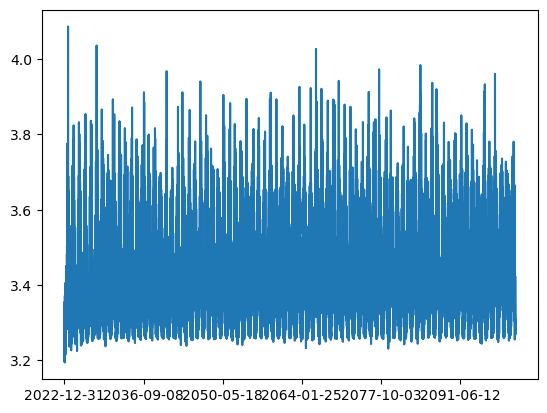

In [19]:
fengqiao_ssp245_pred_df['water_level'].plot()

# LSTM

In [13]:
suzhou_history

,precip,T2M,T2M_MAX,T2M_MIN,ETo_HS,runoff
time,,,,,,
1989-01-01,0.0,4.81,10.07,1.12,1.22,0.018179
1989-01-02,0.0,5.83,12.39,0.13,1.49,0.036330
1989-01-03,0.0,6.70,12.26,3.40,1.32,0.054453
1989-01-04,0.0,7.05,12.15,4.04,1.29,0.072550
1989-01-05,0.5,7.32,12.61,3.19,1.41,0.090633
...,...,...,...,...,...,...
2022-12-27,0.0,2.28,8.31,-2.52,1.18,67.458859
2022-12-28,0.0,3.28,7.74,0.19,1.03,67.461033
2022-12-29,0.0,2.78,6.32,0.17,0.91,67.463204


<Axes: xlabel='time'>

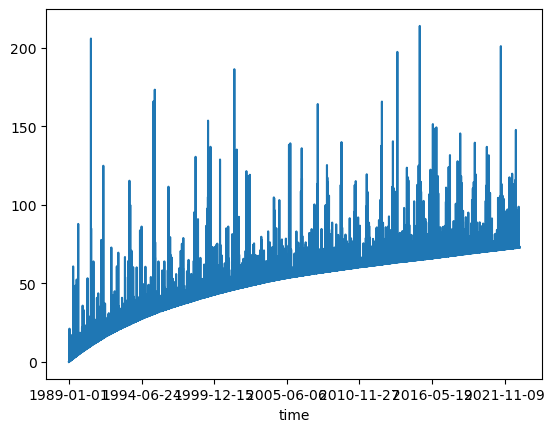

In [14]:
fengqiao_history['runoff'].plot()

<Axes: >

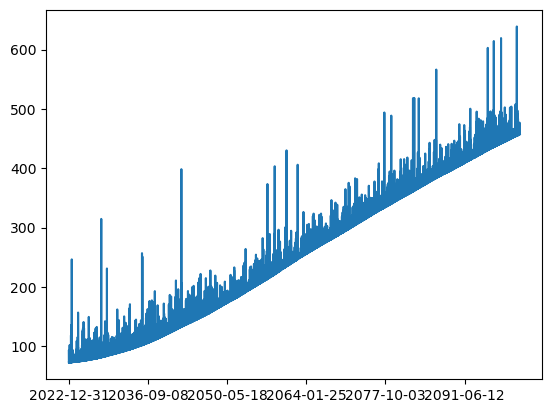

In [13]:
fengqiao_ssp585['runoff'].plot()

In [12]:
history = pd.DataFrame({
    'precip_fengqiao': fengqiao_history['precip'],
    'precip_suzhou': suzhou_history['precip'],
    'T2M': fengqiao_history['T2M'],
    'T2M_MAX': fengqiao_history['T2M_MAX'],
    'T2M_MIN': fengqiao_history['T2M_MIN'],
    'ETo_HS': fengqiao_history['ETo_HS'],
    'runoff_fengqiao': fengqiao_history['runoff'],
    'runoff_suzhou': suzhou_history['runoff']
    
})

ssp245 = pd.DataFrame({
    'precip_fengqiao': fengqiao_ssp245['precip'],
    'precip_suzhou': suzhou_ssp245['precip'],
    'T2M': fengqiao_ssp245['T2M'],
    'T2M_MAX': fengqiao_ssp245['T2M_MAX'],
    'T2M_MIN': fengqiao_ssp245['T2M_MIN'],
    'ETo_HS': fengqiao_ssp245['ETo_HS'],
    'runoff_fengqiao': fengqiao_ssp245['runoff'],
    'runoff_suzhou': suzhou_ssp245['runoff']
})

ssp585 = pd.DataFrame({
    'precip_fengqiao': fengqiao_ssp585['precip'],
    'precip_suzhou': suzhou_ssp585['precip'],
    'T2M': fengqiao_ssp585['T2M'],
    'T2M_MAX': fengqiao_ssp585['T2M_MAX'],
    'T2M_MIN': fengqiao_ssp585['T2M_MIN'],
    'ETo_HS': fengqiao_ssp585['ETo_HS'],
    'runoff_fengqiao': fengqiao_ssp585['runoff'],
    'runoff_suzhou': suzhou_ssp585['runoff']
})

history_wl = suzhou_data[['water_level']]

# save these files 
history.to_csv('../data/results/history.csv')
ssp245.to_csv('../data/results/ssp245.csv')
ssp585.to_csv('../data/results/ssp585.csv')
history_wl.to_csv('../data/results/history_wl.csv')

In [38]:
from darts import TimeSeries
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, r2_score
from darts.metrics import rmse
import matplotlib.pyplot as plt

# 从数据框创建时间序列
series_history = TimeSeries.from_dataframe(history.reset_index(), 'time')
series_wl = TimeSeries.from_dataframe(history_wl.reset_index(), 'time', ['water_level'])

# 数据预处理
scaler_history = Scaler()
scaler_wl = Scaler()

series_history_scaled = scaler_history.fit_transform(series_history)
series_wl_scaled = scaler_wl.fit_transform(series_wl)

wl_train, _ = series_wl_scaled.split_before(0.8)

def evaluate_model(model,past_covariates=None, future_covariates=None):
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=series_wl_scaled, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=10)
    
    # Iterate over the list of TimeSeries objects and call the plot method on each one
    for ts in [series_wl_scaled[-len(backtest)-100:], backtest]:
        ts.plot(label='backtest (n=10)')
    
    print('Backtest RMSE = {}'.format(rmse(series_wl_scaled, backtest)))    

In [39]:
from darts.models import BlockRNNModel

brnn_no_cov = BlockRNNModel(input_chunk_length=30, 
                            output_chunk_length=10, 
                            n_rnn_layers=2)

brnn_no_cov.fit(wl_train, 
                epochs=100, 
                verbose=True)

evaluate_model(brnn_no_cov)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RuntimeError: Lightning can't create new processes if CUDA is already initialized. Did you manually call `torch.cuda.*` functions, have moved the model to the device, or allocated memory on the GPU any other way? Please remove any such calls, or change the selected strategy. You will have to restart the Python kernel.

In [1]:
# 创建并训练LSTM模型
model = RNNModel(
    model='LSTM',
    hidden_dim=20,  # 隐藏层节点数，你可以调整以优化模型性能
    dropout=0.1,  # dropout 率，你可以调整以优化模型性能
    batch_size=16,  # 批量大小，你可以调整以优化模型性能
    n_epochs=100,  # 迭代次数，你可以调整以优化模型性能
    optimizer_kwargs={'lr': 1e-3},  # 优化器参数，你可以调整以优化模型性能
    model_name='LSTM_model', 
    log_tensorboard=True, 
    random_state=42,
    training_length=20,  # 使用过去多少个时间步的数据来预测，你可以调整以优化模型性能
    input_chunk_length=10,  # 使用过去多少个时间步的数据来预测，你可以调整以优化模型性能
    force_reset=True
)

model.fit(series=train_history, past_covariates=train_wl, verbose=True)

# 进行预测
future_covariates = series_wl_scaled.drop_before(train_wl.end_time() - pd.DateOffset(days=1))
prediction_wl = model.predict(n=14, series=train_history, future_covariates=future_covariates)

# 评估模型
print('MAPE =', mape(prediction_wl, val_wl))
print('R^2  =', r2_score(prediction_wl, val_wl))

NameError: name 'RNNModel' is not defined

# Attributes of the dataframes